In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, time
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings


warnings.filterwarnings('ignore')

# Задача
## Создание датафрейма, имитирующего поведение пользователей в рамках активно развивающегося продукта

## Цель подготовить датафрейм:
- позволяющий генерировать данные, позволяющие замерять основные продуктовые метрики
- на основе которого можно создать онлайн ETL для симуляции жизни продукта
- позволяющий после ETL проводить эксперименты, проверку гипотез, АБ/АА тестирование, замер MDE

## Результатом должны стать данные, позволяющие создать пет проект, для отработки навыков аналитика.

#### Исходные данные
- задают стартовые настройки,
- могут изменяться при каждом запуске ноутбука, что изменит итоговую генерацию данных (как по объему так и по содержанию) 

In [2]:
# Задаём временные параметры
start_date = datetime(2025, 1, 1)
end_date = datetime(2025, 12, 31)
days = (end_date - start_date).days + 1

# Показатели прироста пользователей
initial_users = 5  # Начальное количество пользователей
mean_growth = 0.015  # Средний прирост в день (доля - не процент)
growth_std = 0.006  # Отклонение изменения прироста

# Параметры количества просмотров в день для регулярного пользователя
mean_visits_per_day = 12  # Среднее количество визитов в день
std_visits_per_day = mean_visits_per_day * 0.30  # Стандартное отклонение 30%


# Параметры количества просмотров в день для нерегулярного пользователя
lt = 15 # Средний срок жизни непостоянного пользователя
std_lt = 5 # стандартное отклонение в сроке жихни пользователя

# Среднее и стандартное отклонение для логнормального распределения визитов нерегулярных пользователей
mean_visits_per_day_log = 10  # Среднее количество визитов
std_visits_per_day_log = 3  # Стандартное отклонение

## Универсальные функции

### Генерирует время захода юзеров по следующим правилам

#### Основной поток 
(10:00 - 22:30)

Это самая большая часть потока пользователей, которая составляет 70% от общего числа пользователей (значение n * 0.7).
Время для этих пользователей генерируется с использованием логнормального распределения с параметрами mean=2.5 (среднее/матожидание) и sigma=0.5 (стандартное отклонение). Это создает большую концентрацию пользователей в районе 10:00 - 22:30, с возможными пиками в разные часы.


#### Вечерний всплеск 
(21:00 - 22:30)

На всплеск приходится +20% от общего числа пользователей (значение n * 0.2).
Время для этих пользователей генерируется с использованием нормального распределения с параметрами loc=21.75 (среднее = время 21:45) и scale=0.3 (стандартное отклонение от среднего). Это создаёт более плотный поток в поздние часы вечера, около 21:30 - 22:30.

#### Ночной поток
(23:00 - 10:00)

Это 10% от общего числа пользователей (значение n * 0.1).
Для этих пользователей генерируется время с использованием нормального распределения с параметрами loc=4.5 (время 4:30) и scale=1.0, что даёт распределение с пиками около ночи. Однако, время ограничивается в пределах 00:00 - 10:00 с помощью функции np.clip.

In [3]:
# Функция для генерации времени входа
def generate_visit_time(n, date):
    # Основной поток (10:00 - 22:30)
    morning_peak = np.random.lognormal(mean=2.5, sigma=0.5, size=int(n * 0.7))  # Основной поток
    evening_peak = np.random.normal(loc=21.75, scale=0.3, size=int(n * 0.2))  # Вечерний всплеск
    
    # Добавляем ночной поток (23:00 - 10:00), он в 2 раза слабее вечернего
    night_users = int(n * 0.1)  # 10% от общего числа пользователей
    if night_users > 0:
        night_base = np.random.normal(loc=4.5, scale=1.0, size=night_users)  # Среднее 4:30, разброс 1 час
        night_base = np.clip(night_base, 0, 10)  # Ограничиваем 00:00 - 10:00
    else:
        night_base = np.array([])  # Добавляем пустой массив, если пользователей нет

    # Объединяем все периоды
    hours = np.concatenate([morning_peak, evening_peak, night_base])
    hours = np.clip(hours, 0, 22.5)  # Общий диапазон 00:00 - 22:30
    minutes = np.random.randint(0, 60, len(hours))

    return [date + timedelta(hours=float(h), minutes=int(m)) for h, m in zip(hours, minutes)]

### На основе датафрейма с ежедневным количеством посещений для каждого юзера создает строки (объекты) с посещениями

In [4]:
def create_visit_lines(data, target_date):
    target_date = datetime.strptime(target_date , '%Y-%m-%d').date()
    
    data_filtered = data[data['datetime'].dt.date == target_date].copy()
    data_filtered = data_filtered[['datetime', 'user_id', 'first_visit_unique', 'visits_per_day']]
    
    # Для каждого пользователя генерируем визиты
    user_visit_data = []
    
    for _, row in data_filtered.iterrows():
        user_id = row['user_id']
        visits_count = row['visits_per_day']
        first_visit_unique = row['first_visit_unique']
    
        visit_times = generate_visit_time(visits_count, datetime(target_date.year, target_date.month, target_date.day))    
        
        for visit_time in visit_times:
            user_visit_data.append({
                'datetime': visit_time,
                'user_id': user_id,
                'action': 'view',
                'type': 'main', 
            })
    
    # Преобразуем список в DataFrame
    df_visit_times = pd.DataFrame(user_visit_data)
    df_visit_times['datetime'] = pd.to_datetime(df_visit_times['datetime'])
    
    # Добавляем first_visit_unique к каждому user_id
    df_visit_times = df_visit_times.merge(
        data_filtered[['user_id', 'first_visit_unique']], on='user_id', how='left'
    )

    # Фильтруем по first_visit_unique
    df_visit_times = df_visit_times[df_visit_times['datetime'] >= df_visit_times['first_visit_unique']]

    # Удаляем first_visit_unique из финального датасета
    df_visit_times = df_visit_times.drop(columns=['first_visit_unique'])

    return df_visit_times

### Базовый график для отражения динамики измнения количественных данных
(например посещений в день, колебания внутри дня и т.п.)

In [5]:
def line_plot(dataset, figsize = (12, 3),
              label='Количество пользователей', xlabel='Дни',
              ylabel = 'Количество пользователей'):
    plt.figure(figsize=figsize)
    plt.plot(dataset, label=label, color='b')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(label)
    plt.legend()
    plt.grid(True)
    plt.show()

## Этап 1. Генерируем новых пользователей для каждого дня жизни продукта

In [6]:
# Генерируем количество пользователей на каждый день 
daily_users = [initial_users]

# Генерируем количество пользователей на каждый день
daily_users = [initial_users]

for _ in range(1, days):
    prev_users = daily_users[-1]
    adjusted_growth = mean_growth + np.random.normal(0, growth_std)  # Случайное изменение прироста
    new_users = int(np.ceil(prev_users * (1 + adjusted_growth)))  # Применяем изменённый прирост и округляем вверх
    #daily_users.append(max(new_users, prev_users + 1))  # Гарантируем рост хотя бы на 1 пользователя
    daily_users.append(new_users)

daily_users[-10:]

[7226, 7389, 7455, 7564, 7623, 7794, 7915, 8050, 8118, 8238]

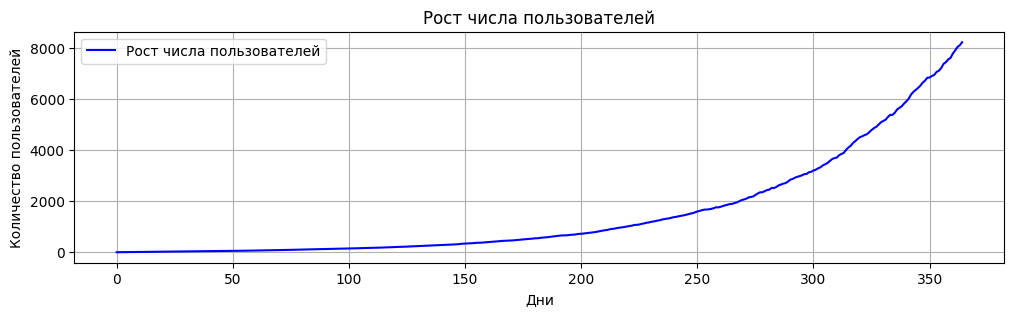

In [7]:
line_plot(daily_users, label='Рост числа пользователей')

#### Создаем датафрейм где отразим приход новых пользователей
с указанием для каждого первого времени пользования продуктом

In [8]:
%%time
# Создаём датафрейм
data = []

user_counter = 1  # Инициализация счётчика для user_id

for i, user_count in enumerate(daily_users):
    date = start_date + timedelta(days=i)
    visit_times = generate_visit_time(user_count, date)

    for visit_time in visit_times:
        data.append([visit_time, user_counter, 'view', 'main', visit_time]) 
        user_counter += 1  # Увеличиваем счётчик для следующего пользователя

# Создаём DataFrame
df = pd.DataFrame(data, columns=["datetime", "user_id", "action", "type", "first_visit"])

# Проверка результата
df.head()

CPU times: user 1.51 s, sys: 27.5 ms, total: 1.54 s
Wall time: 1.23 s


,datetime,user_id,action,type,first_visit
0,2025-01-01 09:48:56.906876,1,view,main,2025-01-01 09:48:56.906876
1,2025-01-01 22:57:00.000000,2,view,main,2025-01-01 22:57:00.000000
2,2025-01-01 15:49:09.087215,3,view,main,2025-01-01 15:49:09.087215
3,2025-01-01 22:16:27.437385,4,view,main,2025-01-01 22:16:27.437385
4,2025-01-02 17:23:44.624904,5,view,main,2025-01-02 17:23:44.624904


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566736 entries, 0 to 566735
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   datetime     566736 non-null  datetime64[ns]
 1   user_id      566736 non-null  int64         
 2   action       566736 non-null  object        
 3   type         566736 non-null  object        
 4   first_visit  566736 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 21.6+ MB


#### Посмотрим визуально внутридневные колебания

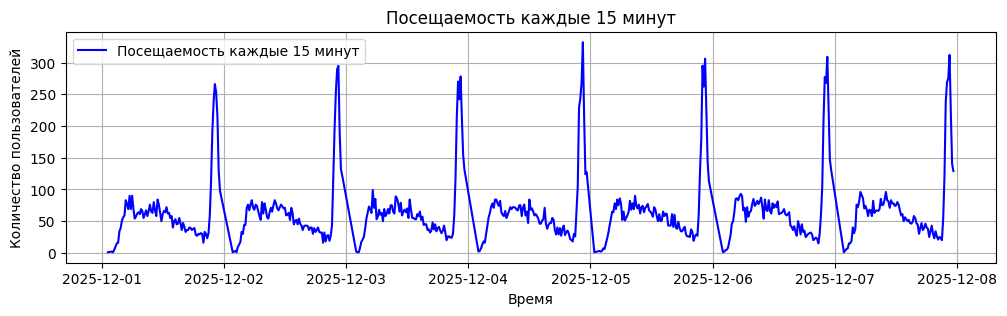

In [10]:
# 1. Фильтруем данные за 7 дней
df_february = df[(df['datetime'] >= '2025-12-01') & (df['datetime'] < '2025-12-8')]

# 2. Округляем время до 15-минутных интервалов
df_february['time_15min'] = df_february['datetime'].dt.floor('15T')

# 3. Группируем по 15-минутным интервалам
df_february = df_february.groupby('time_15min').size()

line_plot(df_february, label='Посещаемость каждые 15 минут', xlabel='Время')


## Этап 2. Разделяем пользователей на постоянных и случайных

In [11]:
# Генерируем вероятность с нормальным распределением
mean_prob = 0.25  # Средняя вероятность 25%
std_dev = 0.10  # Стандартное отклонение 10%

# Создаем столбец permanent_user
df['permanent_user'] = np.random.normal(mean_prob, std_dev, size=len(df)) > np.random.rand(len(df))

In [12]:
df[df.permanent_user == True].shape[0] / df[df.permanent_user == False].shape[0]

0.3327375941228759

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566736 entries, 0 to 566735
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   datetime        566736 non-null  datetime64[ns]
 1   user_id         566736 non-null  int64         
 2   action          566736 non-null  object        
 3   type            566736 non-null  object        
 4   first_visit     566736 non-null  datetime64[ns]
 5   permanent_user  566736 non-null  bool          
dtypes: bool(1), datetime64[ns](2), int64(1), object(2)
memory usage: 22.2+ MB


In [14]:
df.head()

,datetime,user_id,action,type,first_visit,permanent_user
0,2025-01-01 09:48:56.906876,1,view,main,2025-01-01 09:48:56.906876,False
1,2025-01-01 22:57:00.000000,2,view,main,2025-01-01 22:57:00.000000,True
2,2025-01-01 15:49:09.087215,3,view,main,2025-01-01 15:49:09.087215,False
3,2025-01-01 22:16:27.437385,4,view,main,2025-01-01 22:16:27.437385,False
4,2025-01-02 17:23:44.624904,5,view,main,2025-01-02 17:23:44.624904,False


## Этап 3. Рассчитаем для каждого дня количество визитов для постоянных пользователей

In [15]:
%%time

permanent_users = df[df['permanent_user'] == True]  # Фильтруем постоянных пользователей

# Даты для всех визитов (все уникальные даты из df)
dates = pd.to_datetime(df['datetime'].dt.date.unique())

# Получаем список всех user_id для постоянных пользователей
user_ids = permanent_users['user_id'].values

# Создаём массив всех дат и пользователей (по одной строке на каждый день для каждого постоянного пользователя)
dates_repeated = np.tile(dates, len(user_ids))
user_ids_repeated = np.repeat(user_ids, len(dates))


# Векторизуем создание временных меток
# Переводим даты в datetime, добавляем microseconds=1
visit_times = pd.to_datetime(dates_repeated) + timedelta(microseconds=1)

# Создаём DataFrame для добавления визитов
df_permanent_visits = pd.DataFrame({
    'datetime': visit_times,
    'user_id': user_ids_repeated,
    'action': 'view',
    'type': 'main',
    'first_visit': -1,
    'permanent_user': True
})



# Проверка результата
df_permanent_visits = pd.concat([df_permanent_visits, permanent_users])

df_permanent_visits.head()

CPU times: user 3.05 s, sys: 1.2 s, total: 4.26 s
Wall time: 4.53 s


,datetime,user_id,action,type,first_visit,permanent_user
0,2025-01-01 00:00:00.000001,2,view,main,-1,True
1,2025-01-02 00:00:00.000001,2,view,main,-1,True
2,2025-01-03 00:00:00.000001,2,view,main,-1,True
3,2025-01-04 00:00:00.000001,2,view,main,-1,True
4,2025-01-05 00:00:00.000001,2,view,main,-1,True


In [16]:
%%time
# Находим минимальную дату для каждого пользователя (дата начала пользования продуктом)
first_visit_dates = permanent_users.groupby('user_id')['datetime'].min().reset_index()
first_visit_dates

# Переименовываем столбцы для последующего слияния
first_visit_dates.columns = ['user_id', 'first_visit_unique']

# Выполняем merge с оригинальным DataFrame
data = df_permanent_visits.merge(first_visit_dates, on='user_id', how='left')
data.head()

CPU times: user 3.27 s, sys: 1.34 s, total: 4.61 s
Wall time: 5.2 s


,datetime,user_id,action,type,first_visit,permanent_user,first_visit_unique
0,2025-01-01 00:00:00.000001,2,view,main,-1,True,2025-01-01 22:57:00
1,2025-01-02 00:00:00.000001,2,view,main,-1,True,2025-01-01 22:57:00
2,2025-01-03 00:00:00.000001,2,view,main,-1,True,2025-01-01 22:57:00
3,2025-01-04 00:00:00.000001,2,view,main,-1,True,2025-01-01 22:57:00
4,2025-01-05 00:00:00.000001,2,view,main,-1,True,2025-01-01 22:57:00


In [17]:
# Удаляем строки, где datetime меньше first_visit
data = data[data['datetime'] >= data['first_visit_unique']]
data = data.sort_values(by=['datetime', 'user_id'])

data = data.reset_index()
data = data.drop(['first_visit', 'index'	], axis=1)
# Проверка результата
data.head()

,datetime,user_id,action,type,permanent_user,first_visit_unique
0,2025-01-01 22:57:00.000000,2,view,main,True,2025-01-01 22:57:00.000000
1,2025-01-02 00:00:00.000001,2,view,main,True,2025-01-01 22:57:00.000000
2,2025-01-02 12:19:18.700501,6,view,main,True,2025-01-02 12:19:18.700501
3,2025-01-03 00:00:00.000001,2,view,main,True,2025-01-01 22:57:00.000000
4,2025-01-03 00:00:00.000001,6,view,main,True,2025-01-02 12:19:18.700501


#### На данном этапе имеем датафрейм 
где для каждого постоянного пользователя начиная с первого дня его посещения есть запись,

куда далее мы добавим количество просмотров в этот день


Характеристики распредления заданы в начале ноутбука и одинаковы для каждого постоянного пользователя

In [18]:
# Генерируем серию случайных чисел для каждой строки в DataFrame
# Характеристики распредления заданы в начале ноутбука и одинаковы для каждого постоянного пользователя

visits_per_day_series = np.random.normal(mean_visits_per_day, std_visits_per_day, size=len(data))
# Округляем значения, чтобы количество визитов было целым числом
visits_per_day_series = visits_per_day_series.round().astype(int)

# Добавляем эту серию в исходный DataFrame
data['visits_per_day'] = visits_per_day_series

data = data[data['visits_per_day'] > 0]

# Проверка результата
data.head()

,datetime,user_id,action,type,permanent_user,first_visit_unique,visits_per_day
0,2025-01-01 22:57:00.000000,2,view,main,True,2025-01-01 22:57:00.000000,8
1,2025-01-02 00:00:00.000001,2,view,main,True,2025-01-01 22:57:00.000000,10
2,2025-01-02 12:19:18.700501,6,view,main,True,2025-01-02 12:19:18.700501,6
3,2025-01-03 00:00:00.000001,2,view,main,True,2025-01-01 22:57:00.000000,17
4,2025-01-03 00:00:00.000001,6,view,main,True,2025-01-02 12:19:18.700501,12


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9202345 entries, 0 to 9208751
Data columns (total 7 columns):
 #   Column              Dtype         
---  ------              -----         
 0   datetime            datetime64[ns]
 1   user_id             int64         
 2   action              object        
 3   type                object        
 4   permanent_user      bool          
 5   first_visit_unique  datetime64[ns]
 6   visits_per_day      int64         
dtypes: bool(1), datetime64[ns](2), int64(2), object(2)
memory usage: 500.2+ MB


In [20]:
data['visits_per_day'].sum()

110492623

#### На данном этапе имеем ~ 9 млн записей group user-day

##### Общее количество строк при генерации визитов для постоянных пользователей будет ~ 110 млн
##### В связи с чем принимаем решение генерить визиты на стадии подгрузки в БД в рамках ETL

## Этап 4. Исследование для дальнешей доработки данного проекта

### Этап 4.1 Создание пользовательских посещений (просмотров)
Для последнего дня, включенного в период отслеживания продукта создадим построчные посещения для постоянных пользователей

In [21]:
%%time

target_date  = '2025-12-31'
res = create_visit_lines(data, target_date)
display(res.head())
display(res.info())

,datetime,user_id,action,type
0,2025-12-31 13:04:01.289589,2,view,main
1,2025-12-31 15:41:47.643569,2,view,main
2,2025-12-31 06:39:37.094467,2,view,main
3,2025-12-31 08:15:52.122311,2,view,main
4,2025-12-31 22:13:48.787061,2,view,main


<class 'pandas.core.frame.DataFrame'>
Index: 1508823 entries, 0 to 1519619
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   datetime  1508823 non-null  datetime64[ns]
 1   user_id   1508823 non-null  int64         
 2   action    1508823 non-null  object        
 3   type      1508823 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 57.6+ MB


None

CPU times: user 7.64 s, sys: 195 ms, total: 7.83 s
Wall time: 7.88 s


In [22]:
# res.sort_values(by=['datetime', 'user_id']).head(50)
res[res['datetime'].dt.time == time(0, 0, 0, 1)] # проверим что функция отработала верно и не осталось данных со значениями 00:00:00.000001

,datetime,user_id,action,type


#### Функция генерации построковых посещений работае и работает за разумное время

#### Посмотрим на получившиеся данные визуально

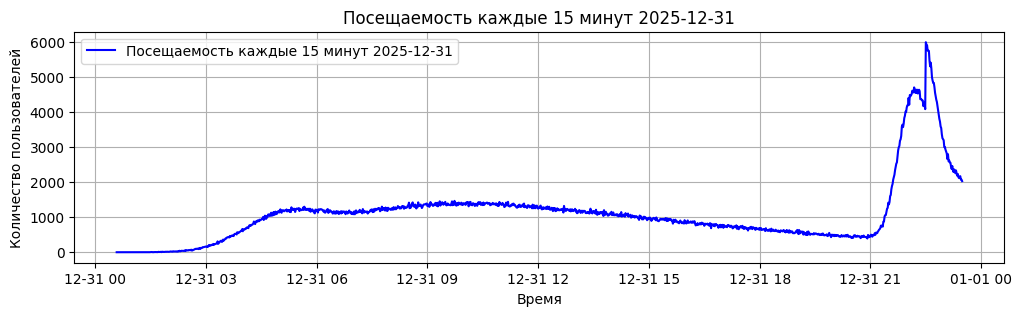

In [23]:
# Округляем время до 1-минутных интервалов
res['time_one_min'] = res['datetime'].dt.floor('1T')

# Группируем по 15-минутным интервалам
visits_one_min = res.groupby('time_one_min').size()

line_plot(visits_one_min, label='Посещаемость каждые 15 минут '+ target_date, xlabel='Время')

### Этап 4.2 Экспериментальный рассчет для каждого дня количества визитов для постоянных пользователей

#### Расчет здесь более сложный, так как у каждого пользователя своя длительность жизни в рамках продукта, 
в связи с чем невозмонжо полностью векторизовать расчет количества дневных посещений в связи с чем генерация данных будет существенно более длительной

In [24]:
%%time

# Фильтруем непостоянных пользователей
non_permanent_users = df[df['permanent_user'] != True]


#Определяем `first_visit_unique` для каждого пользователя
first_visit_dates = non_permanent_users.groupby('user_id')["datetime"].min().reset_index()
first_visit_dates.columns = ['user_id', 'first_visit_unique']


exit_days = np.random.normal(loc=lt, scale=std_lt, size=len(first_visit_dates)) 

# Применяем для каждого пользователя: `exit_day = first_visit_unique + случайное число дней`
first_visit_dates['exit_day'] = first_visit_dates['first_visit_unique'] + pd.to_timedelta(exit_days.astype(int), unit='D')
first_visit_dates.head()

CPU times: user 155 ms, sys: 12.5 ms, total: 168 ms
Wall time: 57.8 ms


,user_id,first_visit_unique,exit_day
0,1,2025-01-01 09:48:56.906876,2025-01-22 09:48:56.906876
1,3,2025-01-01 15:49:09.087215,2025-01-12 15:49:09.087215
2,4,2025-01-01 22:16:27.437385,2025-01-25 22:16:27.437385
3,5,2025-01-02 17:23:44.624904,2025-01-19 17:23:44.624904
4,7,2025-01-02 09:01:49.654808,2025-01-19 09:01:49.654808


In [25]:
%%time

# Создадим список для хранения датафреймов по каждому пользователю
dfs = []

for _, row in tqdm(first_visit_dates.iterrows(), total=first_visit_dates.shape[0], desc='Generating visit qty'):
    user_id = row['user_id']
    first_visit = row['first_visit_unique']
    exit_day = row['exit_day']
    
    # Генерация всех дат от first_visit до exit_day
    dates = pd.date_range(start=first_visit, end=exit_day, freq='D')

    # Генерация количества визитов для каждой даты по логнормальному распределению
    visits_per_day = np.random.lognormal(mean=np.log(mean_visits_per_day_log), sigma=std_visits_per_day_log, size=len(dates)).astype(int)

    # Создаем мини-датафрейм для текущего пользователя
    user_df = pd.DataFrame({
        'datetime': [datetime.combine(date, datetime.min.time()) + timedelta(microseconds=1) for date in dates],
        'user_id': user_id,
        'action': 'view',
        'type': 'main',
        'first_visit': first_visit,
        'permanent_user': False,
        'visits_per_day': visits_per_day
    })

    # Добавляем мини-датафрейм в список
    dfs.append(user_df)

# Объединяем все мини-датафреймы в один
df_visit_times = pd.concat(dfs, ignore_index=True)

# Проверяем результат
df_visit_times.head()


Generating visit qty: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 425242/425242 [02:12<00:00, 3221.50it/s]


CPU times: user 2min 32s, sys: 11.5 s, total: 2min 44s
Wall time: 2min 45s


,datetime,user_id,action,type,first_visit,permanent_user,visits_per_day
0,2025-01-01 00:00:00.000001,1,view,main,2025-01-01 09:48:56.906876,False,65
1,2025-01-02 00:00:00.000001,1,view,main,2025-01-01 09:48:56.906876,False,22
2,2025-01-03 00:00:00.000001,1,view,main,2025-01-01 09:48:56.906876,False,47
3,2025-01-04 00:00:00.000001,1,view,main,2025-01-01 09:48:56.906876,False,14
4,2025-01-05 00:00:00.000001,1,view,main,2025-01-01 09:48:56.906876,False,149


In [26]:
df_visit_times.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6592400 entries, 0 to 6592399
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   datetime        datetime64[ns]
 1   user_id         int64         
 2   action          object        
 3   type            object        
 4   first_visit     datetime64[ns]
 5   permanent_user  bool          
 6   visits_per_day  int64         
dtypes: bool(1), datetime64[ns](2), int64(2), object(2)
memory usage: 308.1+ MB


In [27]:
df_visit_times['visits_per_day'].sum()

6012945415

# Вывод:
## проект требует доработки
- прирост пользователей выглядит ненатурально (резкий экспоненциальный рост)
- количество генерируемых данных уже на данном этапе чрезмерно большое (также вызвано резким ростом) для целей проекта
- на следующем этапе прирост пользователей рассчитаем лограифмической функцией с добавлением шума, рассчитанного на основании нормального распределения